In [86]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import math
df = pd.read_csv('pgdata.csv')
df["eddm_lagged"] = df["eddms"].shift(-1)
df = df.dropna(subset=['eddm_lagged'])

In [87]:
#Convert into numpy arrays 
X_train = df['eddm_lagged'].to_numpy()
y = df['sales'].to_numpy()

In [88]:
#Normalize the data (Prevent huge gradient, speed, more Interpretable)
#for X
X_mean =  X_train.mean()
X_std = X_train.std()
X_train = (X_train - X_mean) / X_std

#for y
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

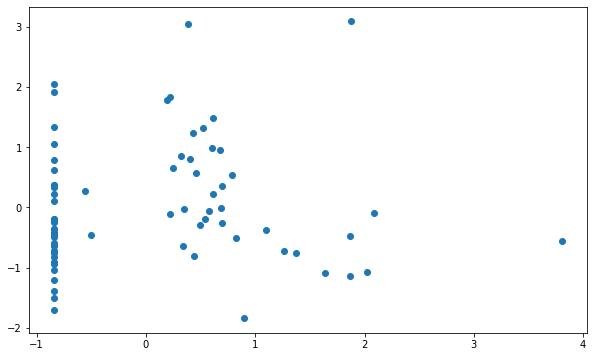

In [89]:
plt.figure(figsize=(10,6))
plt.scatter(X_train, y)


In [90]:
#Calculate the cost function:
def calculate_cost(w, b, x, y):
    """
    Calculates the MSE cost for univariate linear regression.
    Parameters:
    w : float, Weight (slope) of the linear model.
    b : float, Bias (intercept) of the linear model.
    x : ndarray, Input feature array (e.g., normalized EDDMS values).
    y : ndarray, Target output array (e.g., normalized sales values).
    Returns:
    total_cost : float
        The average cost computed as (1/2m) * sum((f_wb - y)^2), 
        where f_wb = w * x + b for each training example.
    """
    m = len(x)
    total_cost = 0
    for i in range(m):
        f_wb = w * X_train[i] + b # the prediction of the model
        err = (f_wb - y[i]) ** 2 #Squared Error 
        total_cost += err
    return total_cost / (2 * m)

In [91]:
#compute the gradients for gradient descent 
def compute_gradient(x, y, w, b):
    """
    Calulcates the derivative of the cost function for the parameters.
    Parameters:
    x : ndarray, Input feature array (e.g., normalized EDDMS values).
    y : ndarray, Target output array (e.g., normalized sales values).
    w : float, Weight (slope) of the linear model.
    b : float, Bias (intercept) of the linear model.
    Returns:
    dj_dw: float, partial derivative of the cost function w.r.t w
    dj_db: float, partial derivative of the cost function w.r.t b
    """
    dj_dw = 0
    dj_db = 0 
    
    m = len(x)
    
    for i in range(m):
        f_wb = x[i] * w + b
        err = f_wb - y[i]
        dj_db += err
        dj_dw += (err * x[i])
        
    return (dj_dw / m) , (dj_db / m)

In [92]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters, calculate_cost, compute_gradient):
    """
    Performs Gradient Descent over the data to fit the w,b by taking num_iters iteration 
    using the learning rate alpha. 
    Parameters:
    x : ndarray, Input feature array (e.g., normalized EDDMS values).
    y : ndarray, Target output array (e.g., normalized sales values).
    w_in: float, The initial w we provide for gradient descent 
    b_in: float, The inital b we provide for gradient descent 
    alph: float, learning rate 
    num_iters: number of iterations to do the gradient descent 
    cost_function: function to produce the total cost with the parameters 
    compute_gradient: function to compute the partial derivatives of the cost function 
    Returns:
    w: float, The parameter w after performing gradient descent 
    b: float, The parameter b after performing gradient descent 
    J_history: The history of change in the cost function (for graphing)
    w_history: The history of change in the perameter w (for graphing)
    b_history: The history of change in the parameter b (for graphing)
    """
    w = w_in
    b = b_in
    J_history = []
    w_history = []
    b_history = []
    
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(x,y,w,b)
        
        w = w - (alpha * dj_dw)
        b = b - (alpha * dj_db)
        # Save cost J at each iteration
        J_history.append(calculate_cost(w,b,x,y))
        w_history.append(w)
        b_history.append(b)
    return w, b, J_history, w_history, b_history

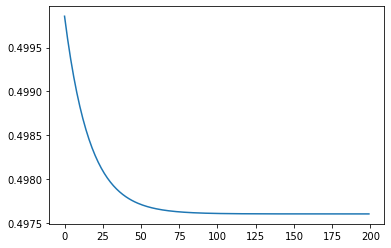

In [93]:
w_init = 0
b_init = 0
iterations = 200
tmp_alpha = 3.0e-2

w,b,J_history, w_history, b_history = gradient_descent(X_train, y, w_init, b_init, tmp_alpha, iterations, calculate_cost, compute_gradient)
plt.plot(J_history)

In [94]:
def test_accuracy(x, y, w, b):
    """
    Tests the Acruaccy of the model with a ten percent error margin on trying to predict 
    the training data.
    Parameters:
    x : ndarray, Input feature array (e.g., normalized EDDMS values).
    y : ndarray, Target output array (e.g., normalized sales values).
    w: float, The parameter w after performing gradient descent 
    b: float, The parameter b after performing gradient descent 
    Returns:
    accuracy: float, percentage of the numbers guessed correclty out of all the training 
    examples. 
    """
    m = len(x)
    correct_results = 0
    for i in range(m):
        prediction_norm = w * x[i] + b

        prediction = prediction_norm * y_std + y_mean
        actual = y[i] * y_std + y_mean

        error = actual * 0.10
        
        if actual - error <= prediction <= actual + error:
            correct_results += 1
    accuracy = (correct_results / m) * 100
    return accuracy

In [95]:
def predict(eddms, w, b):
    """
    Predicts weekly sales from the eddms in dollar amount. 
    Parameters:
    eddms: float, the dollar amount of weekly eddm spend
    w: float, The parameter w after performing gradient descent 
    b: float, The parameter b after performing gradient descent 
    Returns:
    unorm_prediction: float, returns the unormalized results from the amount of eddms spent. 
    """
    normalized_eddms = (eddms - X_mean) / X_std #normalize the eddm amount in dollars 
    norm_prediction = (normalized_eddms * w) + b # predict a value with w and b 
    unnorm_predcition =  norm_prediction * y_std + y_mean
    return unnorm_predcition

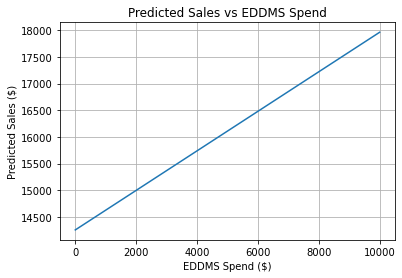

In [123]:
#how many eddms do you have to send out for the price to really go up?
eddm_amounts = np.arange(0, 10001, 100)
sales_based_on_eddms = []
for eddm_amount in eddm_amounts:
    sales_based_on_eddms.append(predict(eddm_amount, w, b))
plt.plot(eddm_amounts, sales_based_on_eddms)
plt.xlabel("EDDMS Spend ($)")
plt.ylabel("Predicted Sales ($)")
plt.title("Predicted Sales vs EDDMS Spend")
plt.grid(True)
plt.show()

In [113]:
#Test with Scikit learn to see if the results are sane 
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train.reshape(-1,1), y)
w_sklearn = model.coef_[0]
b_sklean = model.intercept_
y_pred_norm = model.predict(X_train.reshape(-1, 1))
print(test_accuracy(X_train, y, w_sklearn, b_sklean))
print(test_accuracy(X_train, y, w, b))

61.33333333333333
61.33333333333333


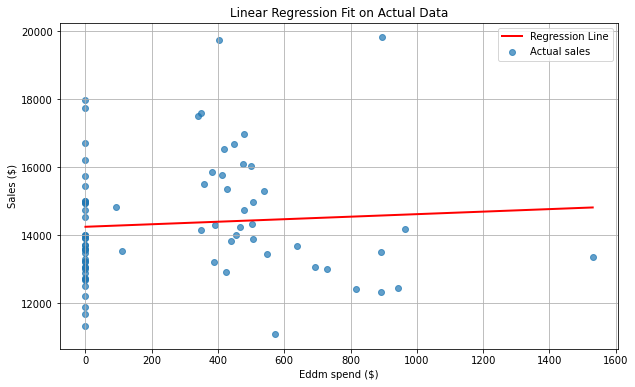

In [122]:
#range of eddm spend
x_real = np.linspace(df['eddm_lagged'].min(), df['eddm_lagged'].max(), 50)
x_norm = (x_real - X_mean) / X_std
y_pred_norm = w * x_norm + b 
y_pred = (y_pred_norm * y_std) + y_mean
plt.figure(figsize=(10,6))
plt.scatter(df['eddm_lagged'], df['sales'], alpha =0.7, label = 'Actual sales ')
plt.plot(x_real, y_pred, color = 'red', linewidth = 2, label = 'Regression Line')
plt.xlabel("Eddm spend ($)")
plt.ylabel("Sales ($)")
plt.title("Linear Regression Fit on Actual Data")
plt.legend()
plt.grid(True)